# <span style="color:red">Importing Data and getting initial info</span>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import seaborn as sns
import numpy as np

from unidecode import unidecode
from nltk.tokenize import WordPunctTokenizer
from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer
from wordcloud import WordCloud
from string import punctuation
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import train_test_split, GroupKFold, KFold, StratifiedShuffleSplit, StratifiedKFold, cross_validate
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# UNCOMMENT THIS PART WHEN RUNNING THIS NOTEBOOK FOR THE FIRST TIME
# nltk.download() 

In [2]:
data = pd.read_csv("./data/feeds_label.csv")
data['Category'] = 'news' # TODO: REMOVE THIS LATER ON
data = data.dropna(subset=['Title', 'Content']) # TODO: REMOVE  THIS LATER ON

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 886 entries, 0 to 887
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Id           886 non-null    int64 
 1   Pick_count   886 non-null    int64 
 2   Content      886 non-null    object
 3   Title        886 non-null    object
 4   Label_Train  886 non-null    object
 5   Category     886 non-null    object
dtypes: int64(2), object(4)
memory usage: 48.5+ KB


# <span style="color:red">Data Pre-processing</span>

In [4]:
feed_news = data.query('Category == "news"').copy()
feed_news = feed_news[['Id', 'Title', 'Content', 'Label_Train']]

### Creating a column with title and content together

In [5]:
feed_news['Title_and_Content'] = feed_news['Title'] + ' ' + feed_news['Content']

### Transforming text to lower_case

In [6]:
feed_news['Title_and_Content'] = feed_news['Title_and_Content'].str.lower()
feed_news['Label_Train'] = feed_news['Label_Train'].str.lower()

### Removing stopwords

In [7]:
pattern = r'\b(?:{})\b'.format('|'.join(stopwords.words('portuguese'))) 
feed_news['Without_stopwords'] = feed_news['Title_and_Content'].str.replace(pattern, '')

### Removing punctuations

In [8]:
feed_news['Without_punctuations'] = feed_news['Without_stopwords'].str.replace('[^\w\s]','')

### Removing accents

In [9]:
def remove_accents(text):
    return unidecode(text)

In [10]:
feed_news['Without_accents'] = feed_news['Without_punctuations'].apply(remove_accents)

### Removing morphological affixes from words (Stemmer)

In [11]:
def stem_words(text):    
    tokenizer = WordPunctTokenizer()
    stemmer = RSLPStemmer()
    words = tokenizer.tokenize(text)
    stemmed_words = map(lambda word : stemmer.stem(word), words)

    return ' '.join(stemmed_words)

In [12]:
feed_news['Without_morphological_affixes'] = feed_news['Without_accents'].apply(stem_words)

# <span style="color:red">WordClouds and Frequency Distributions</span>

### Function to generate wordclouds given a text

In [13]:
def generate_wordcloud(text, figsize=(20,8)):
    wordcloud = WordCloud(max_words=100, 
                          width=900,
                          height=500,
                          max_font_size=350,
                          collocations=False,
                          normalize_plurals=False).generate(text)
    plt.figure(figsize=figsize)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

### Function to get the full content and title in one string

In [14]:
def full_content_and_title(series):
    return series.str.cat(sep=" ")

### Function to generate a frequency distribution 

In [15]:
def generate_freq_dist_plot(text, max_words=25):
    words = WordPunctTokenizer().tokenize(text)
    words_that_apper_the_most = pd.Series(words).value_counts().nlargest(max_words)

    ax = sns.barplot(x=words_that_apper_the_most.index, y=words_that_apper_the_most.values)
    ax.figure.set_size_inches(20, 7)
    
    return words_that_apper_the_most

### For raw data

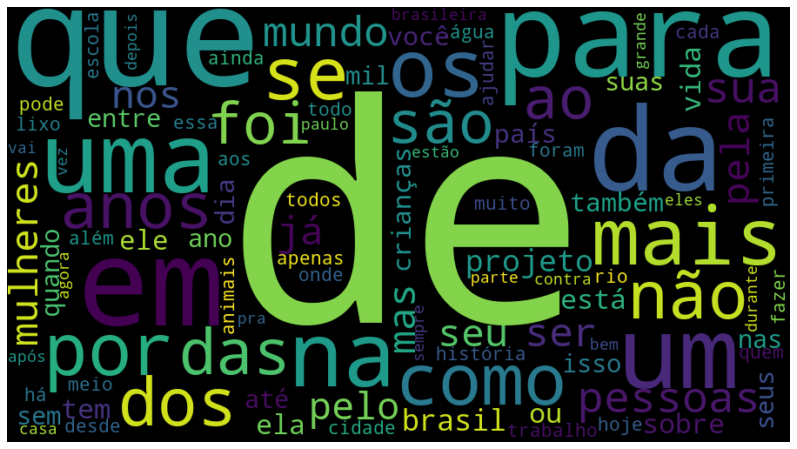

,       5313
de      4742
.       3214
a       3079
e       2675
o       2409
que     1986
em      1495
do      1448
para    1417
da      1333
um       987
com      969
uma      941
é        887
no       876
na       783
os       630
mais     598
as       536
por      498
se       494
como     473
-        435
não      403
dtype: int64

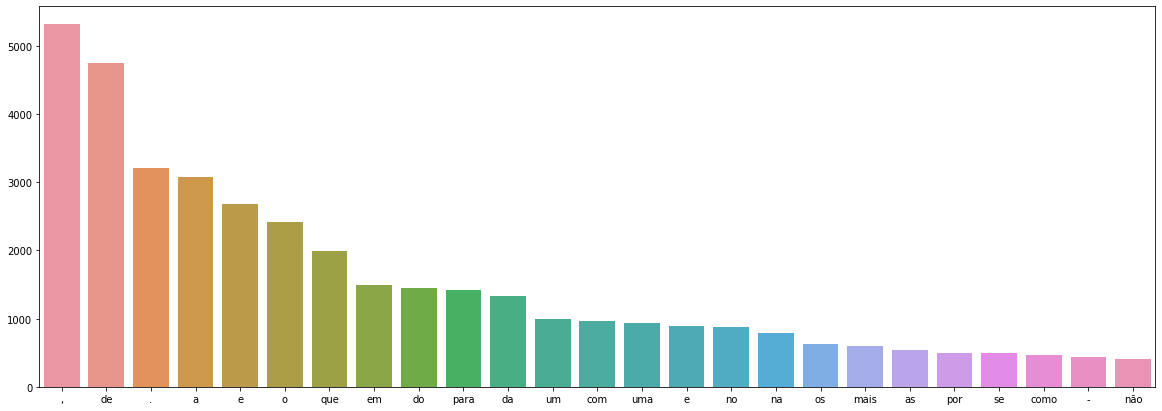

In [16]:
text = full_content_and_title(feed_news['Title_and_Content'])

generate_wordcloud(text)
generate_freq_dist_plot(text)

### Without stop  words

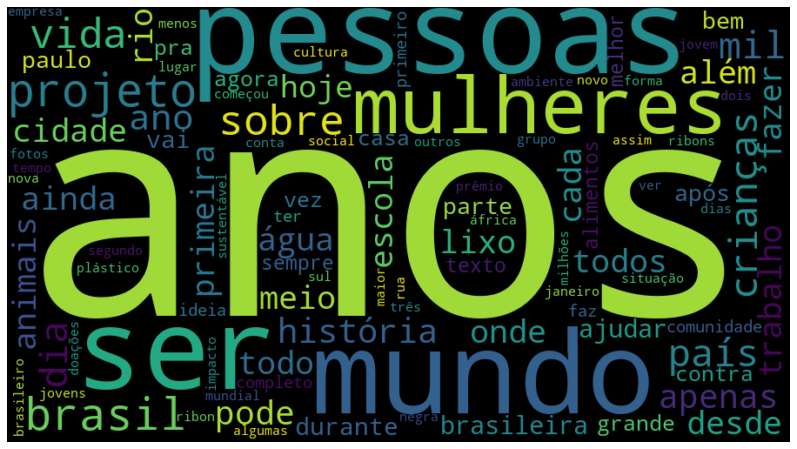

,           5308
.           3210
-            415
anos         371
“            307
(            298
:            284
pessoas      252
mundo        232
–            230
ser          224
!            209
mulheres     202
projeto      194
brasil       187
sobre        162
vida         156
crianças     142
país         137
dia          136
)            136
mil          127
”,           125
ano          118
?            116
dtype: int64

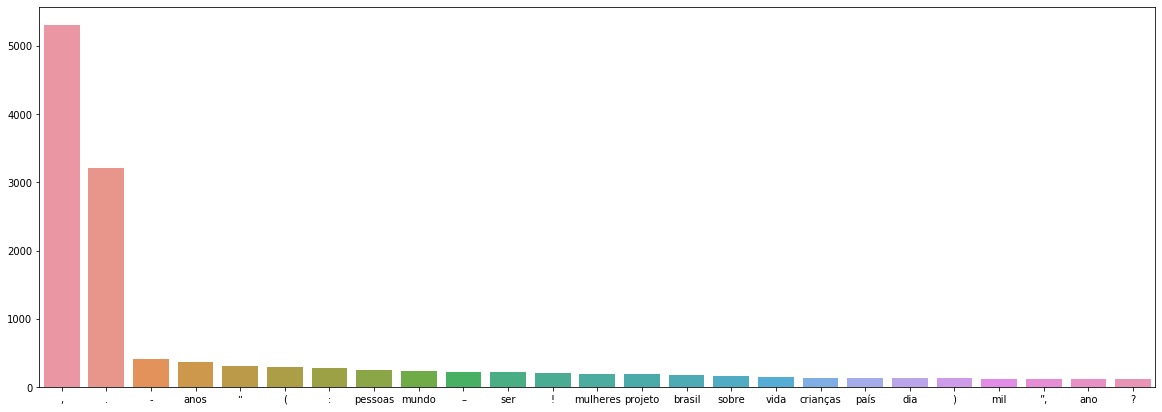

In [17]:
text = full_content_and_title(feed_news['Without_stopwords'])

generate_wordcloud(text)
generate_freq_dist_plot(text)

### Without punctuations

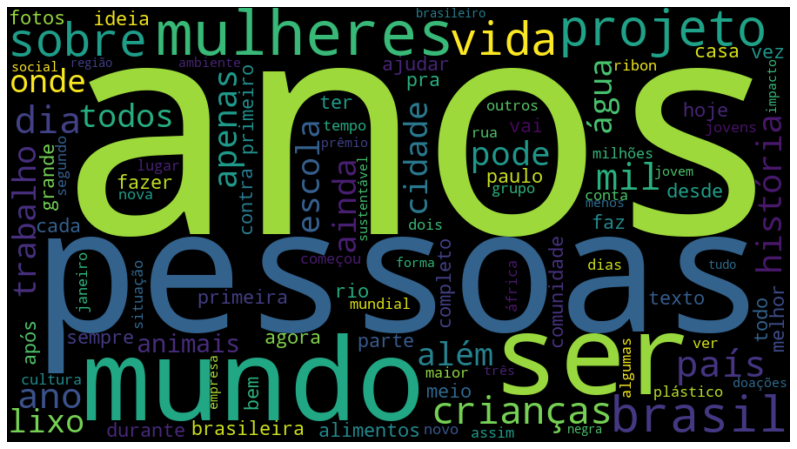

anos        370
pessoas     252
mundo       232
ser         224
mulheres    202
projeto     193
brasil      185
sobre       162
vida        156
crianças    142
país        137
dia         136
mil         127
ano         118
história    108
apenas      104
pode        103
todos        99
ainda        99
além         98
onde         97
trabalho     96
água         94
cidade       94
escola       92
dtype: int64

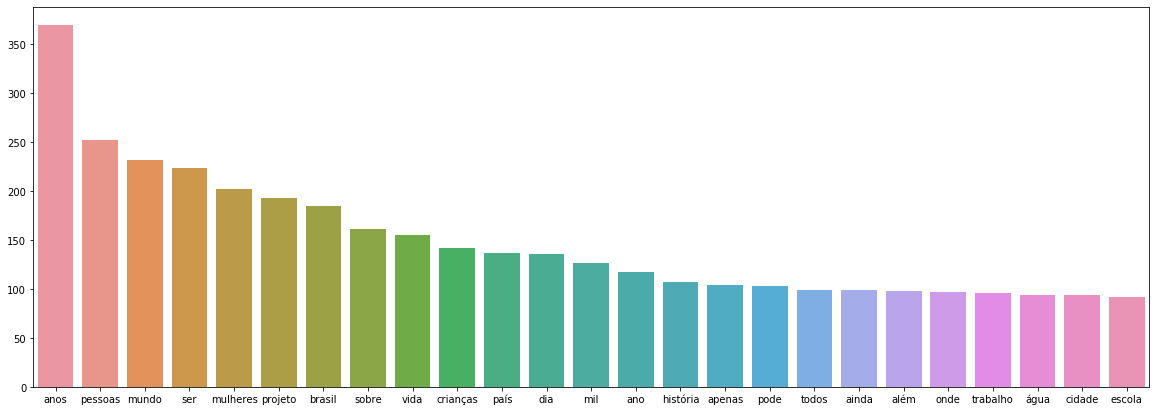

In [18]:
text = full_content_and_title(feed_news['Without_punctuations'])

generate_wordcloud(text)
generate_freq_dist_plot(text)

### Without accents

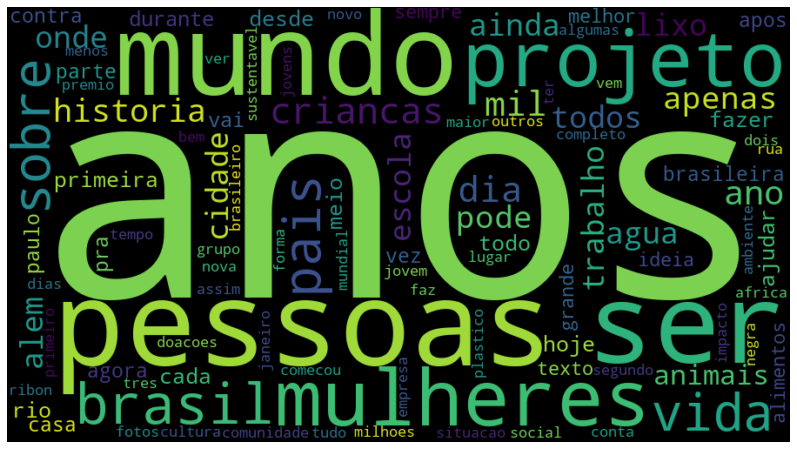

anos        370
pessoas     252
mundo       232
ser         224
mulheres    202
projeto     193
brasil      185
sobre       162
vida        156
pais        155
criancas    142
dia         136
mil         127
ano         118
historia    108
pode        104
apenas      104
ainda        99
todos        99
alem         98
onde         97
trabalho     96
cidade       94
agua         94
lixo         92
dtype: int64

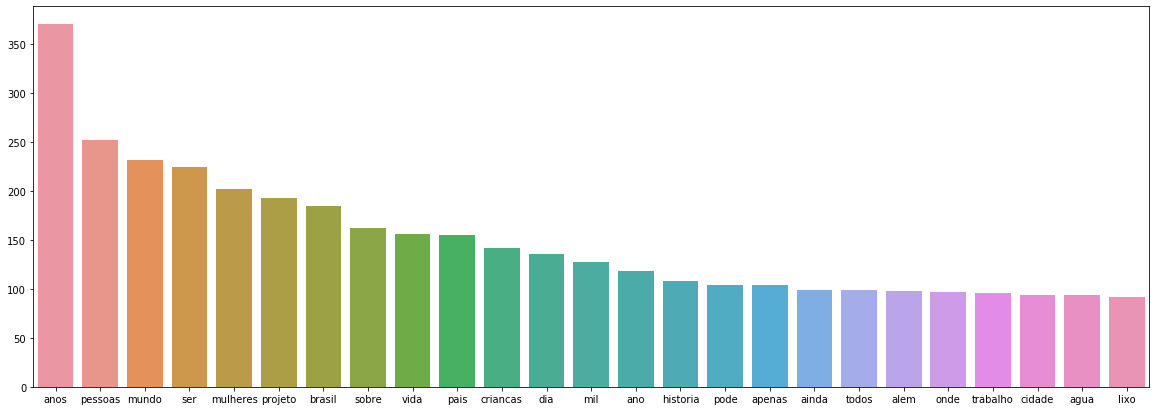

In [19]:
text = full_content_and_title(feed_news['Without_accents'])
generate_wordcloud(text)
generate_freq_dist_plot(text)

### Without morphological affixes (Stemmed)

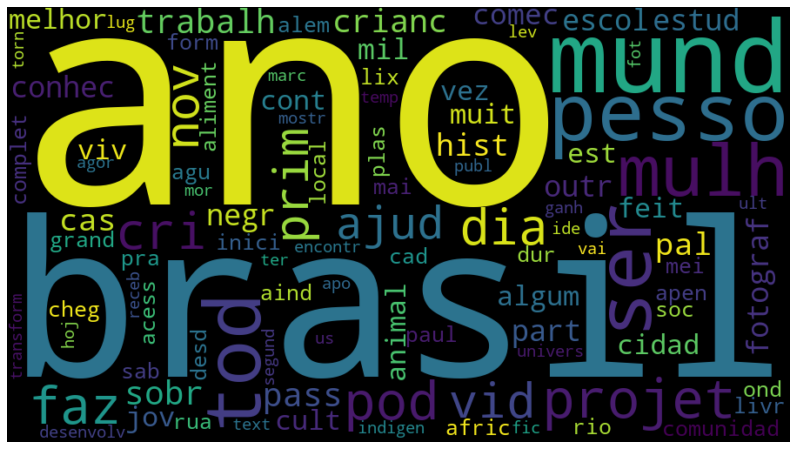

ano         488
brasil      392
mund        300
pesso       272
tod         257
ser         249
mulh        246
projet      231
pod         218
faz         212
cri         208
dia         198
prim        182
nov         181
vid         179
ajud        178
trabalh     178
sobr        176
pass        174
crianc      163
cas         156
pal         155
hist        148
escol       143
fotograf    140
dtype: int64

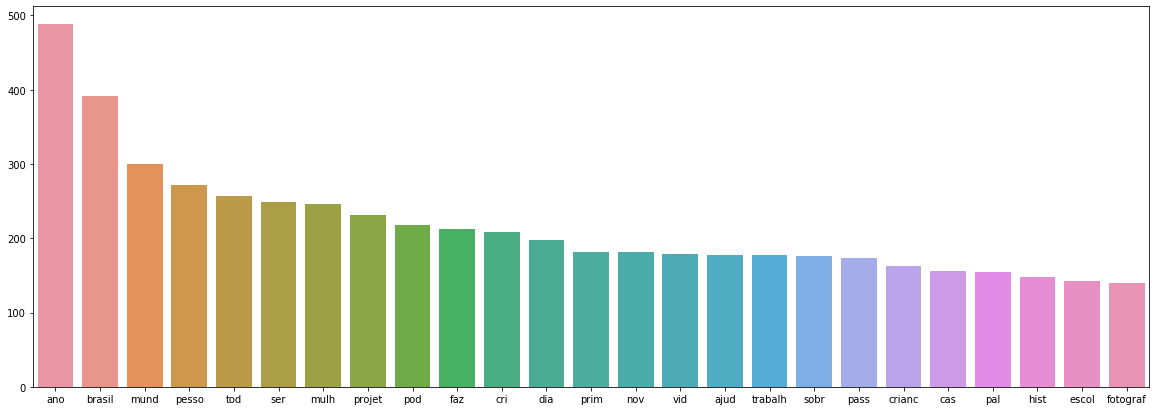

In [20]:
text = full_content_and_title(feed_news['Without_morphological_affixes'])
generate_wordcloud(text)
generate_freq_dist_plot(text)

# <span style="color:red">Applying Machine Learning Algorithms</span>

### Function to run the model and get the accuracies for each column

In [23]:
def get_mean_accuracies(model=LogisticRegression(), 
                        ngram_range=(1,1), 
                        columns_to_compare=['Without_stopwords', 'Without_punctuations', 
                                            'Without_accents', 'Without_morphological_affixes']):
    mean_accuracies = np.array([])
    y = feed_news['Label_Train']

    for column in columns_to_compare:
        X = feed_news[column]
        tfidf_vectorizer = TfidfVectorizer(lowercase=False, ngram_range=ngram_range)

        tfidf_pipeline = Pipeline([
            ('vectorizing', tfidf_vectorizer),
            ('classifier', model)
        ])
        
        tfidf_results = cross_validate(tfidf_pipeline, X, y, cv=StratifiedKFold(shuffle=True))

        mean_accuracies = np.append(mean_accuracies, tfidf_results['test_score'].mean())
        
    return mean_accuracies

### Using Bag Of Words with TF-IDF Vectorizer in each column

In [24]:
COLUMNS_TO_COMPARE = ['Without_stopwords', 'Without_punctuations', 'Without_accents', 'Without_morphological_affixes']
model = SGDClassifier()

mean_accuracies = get_mean_accuracies(model=model, 
                                      columns_to_compare=COLUMNS_TO_COMPARE, 
                                      ngram_range=(1,3))

In [25]:
comparison = pd.Series(mean_accuracies*100, index=COLUMNS_TO_COMPARE)
comparison

Without_stopwords                53.946550
Without_punctuations             53.617089
Without_accents                  52.712499
Without_morphological_affixes    57.223386
dtype: float64

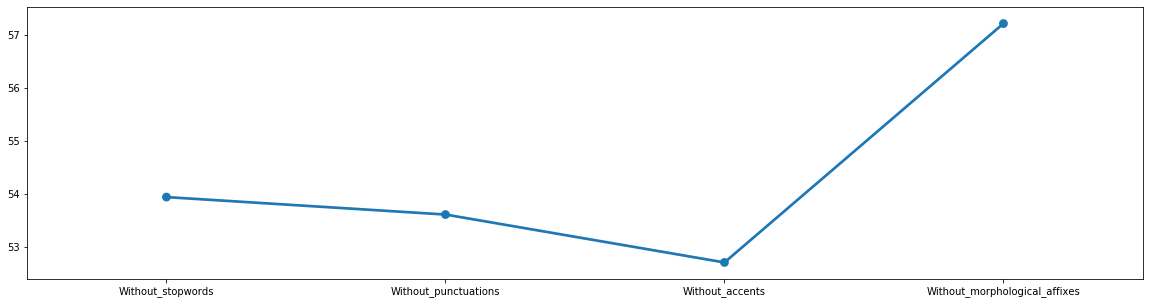

In [26]:
ax = sns.pointplot(x=comparison.index, y=comparison.values)
ax.figure.set_size_inches(20, 5)